In [1]:
# Nestor Cabello, Elham Naghizade, Jianzhong Qi, Lars Kulik
# Fast, accurate and explainable time series classification through randomization.
# Data Min Know Disc (2023)

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from rSTSF_functions import *

In [3]:
dset_name = "ItalyPowerDemand"
print("Dataset: ", dset_name)
X_train, y_train, X_test, y_test = getTrainTestSets(dset_name)
clf = rstsf()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)       
accu = np.sum(y_pred==y_test)/len(y_test)
print('accuracy: ', accu)

Dataset:  ItalyPowerDemand
accuracy:  0.9737609329446064


In [4]:
# Get the information (i.e., starting and ending indices, aggregation function and time series representation) from each relevant interval feature
trees_start_idx,trees_end_idx,trees_agg_fns,trees_repr_types = get_lst_start_ending_indices(clf.relevant_caf_idx_per_tree, clf.all_candidate_agg_feats)

In [5]:
# Get the matrix of predictions
all_trees_predict = clf.get_predictions_matrix()

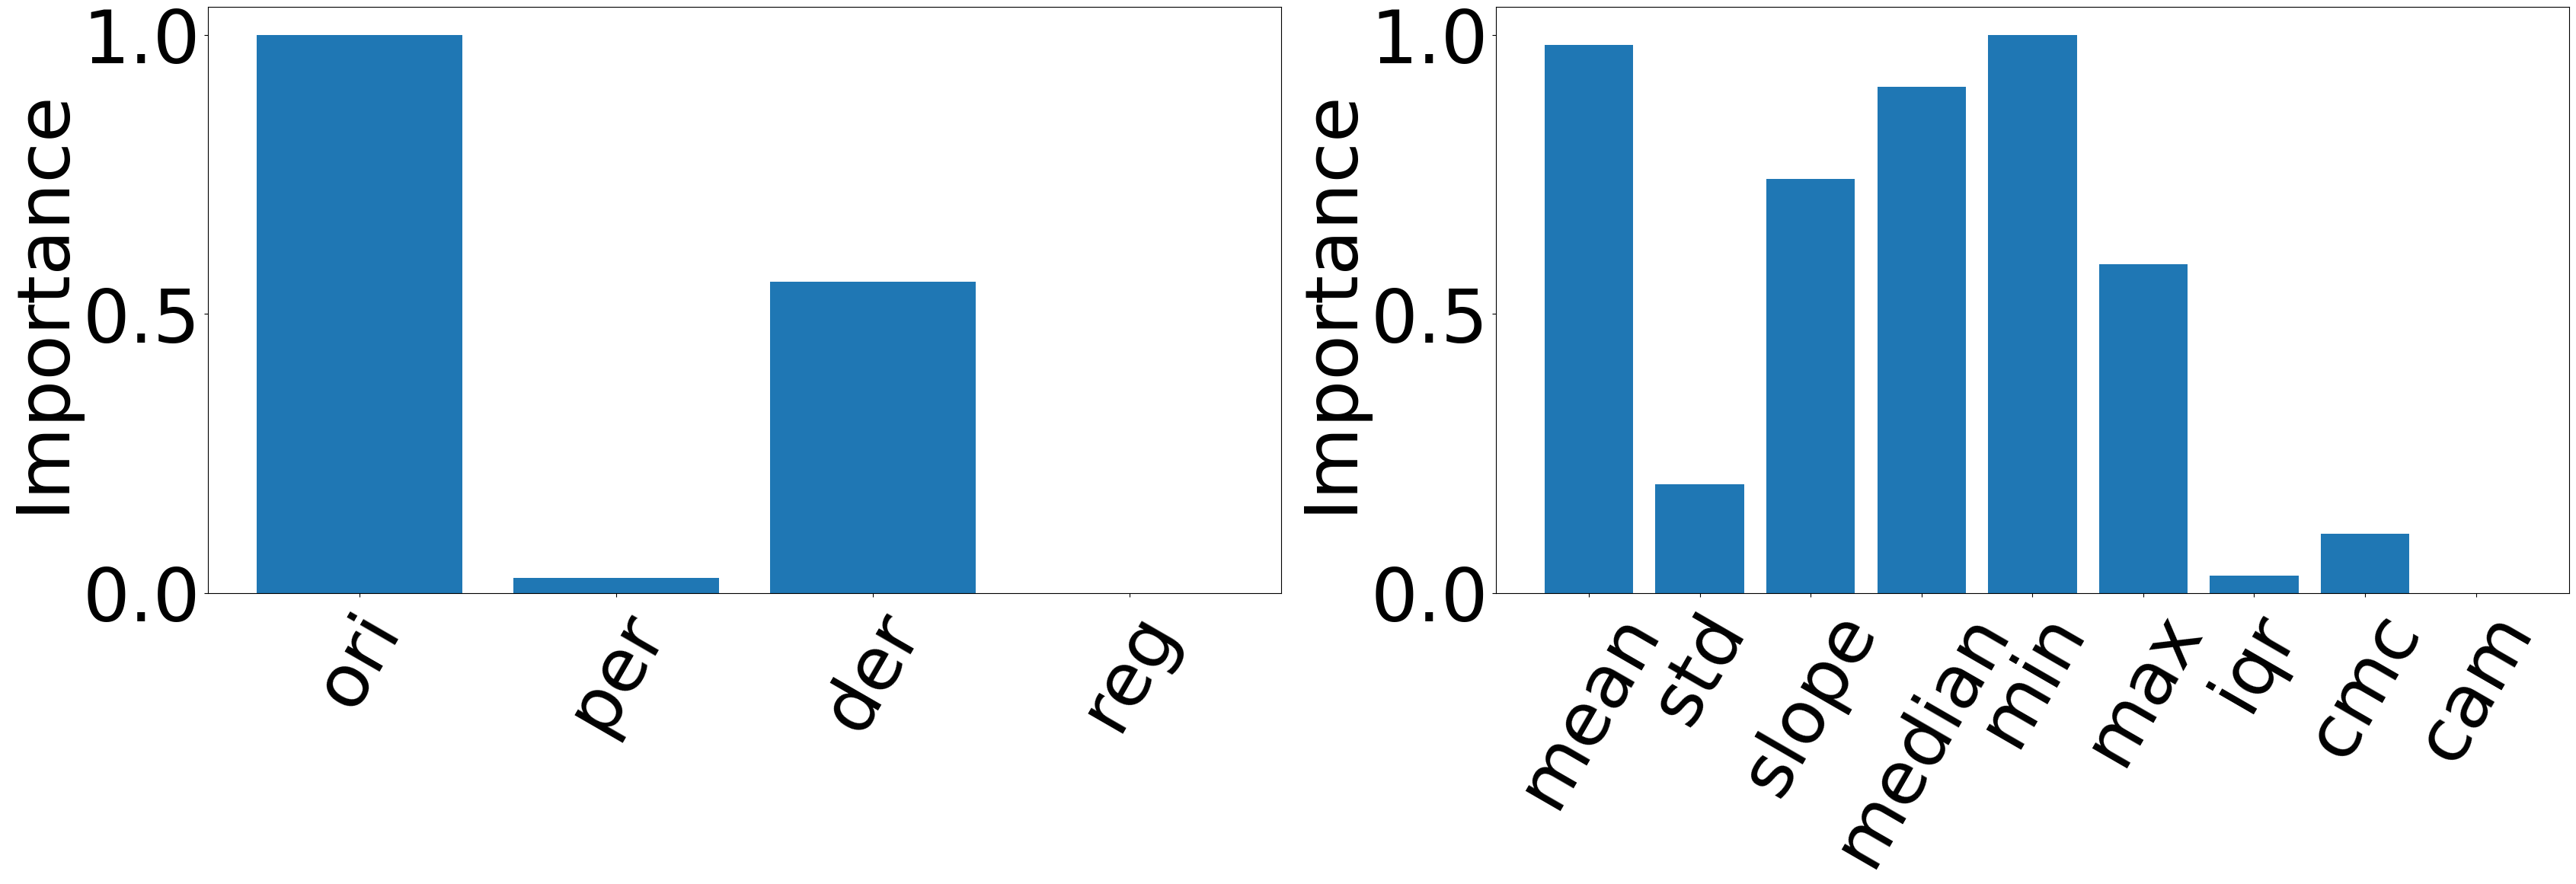

In [6]:
fig, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(40,10))

#Compute the importance of each time series representation
repr_importances = clf.get_repr_importances()
normalized_repr_importances = (repr_importances-np.min(repr_importances))/(np.max(repr_importances)-np.min(repr_importances))
ax1.bar([1,2,3,4], normalized_repr_importances, tick_label=["ori","per","der","reg"])
ax1.tick_params(axis='x', labelsize=70, labelrotation=60)


most_important_representation = 1 #original (raw) time series representation

#Compute the importance of each aggregation function 
#(according to the relevant features found with the most important TS representation)
stats_importances = clf.get_stats_importances(most_important_representation)
normalized_stats_importances = (stats_importances-np.min(stats_importances))/(np.max(stats_importances)-np.min(stats_importances))
ax2.bar([1,2,3,4,5,6,7,8,9], normalized_stats_importances, tick_label=["mean","std","slope","median","min","max","iqr","cmc","cam"])
ax2.tick_params(axis='x', labelsize=70, labelrotation=60)

for ax in fig.get_axes():
    ax.tick_params(axis='y', labelsize=70)
    ax.set_ylabel('Importance', fontsize=70)

representation type:  1
agg fn:  <function amin at 0x107a9a8b0>


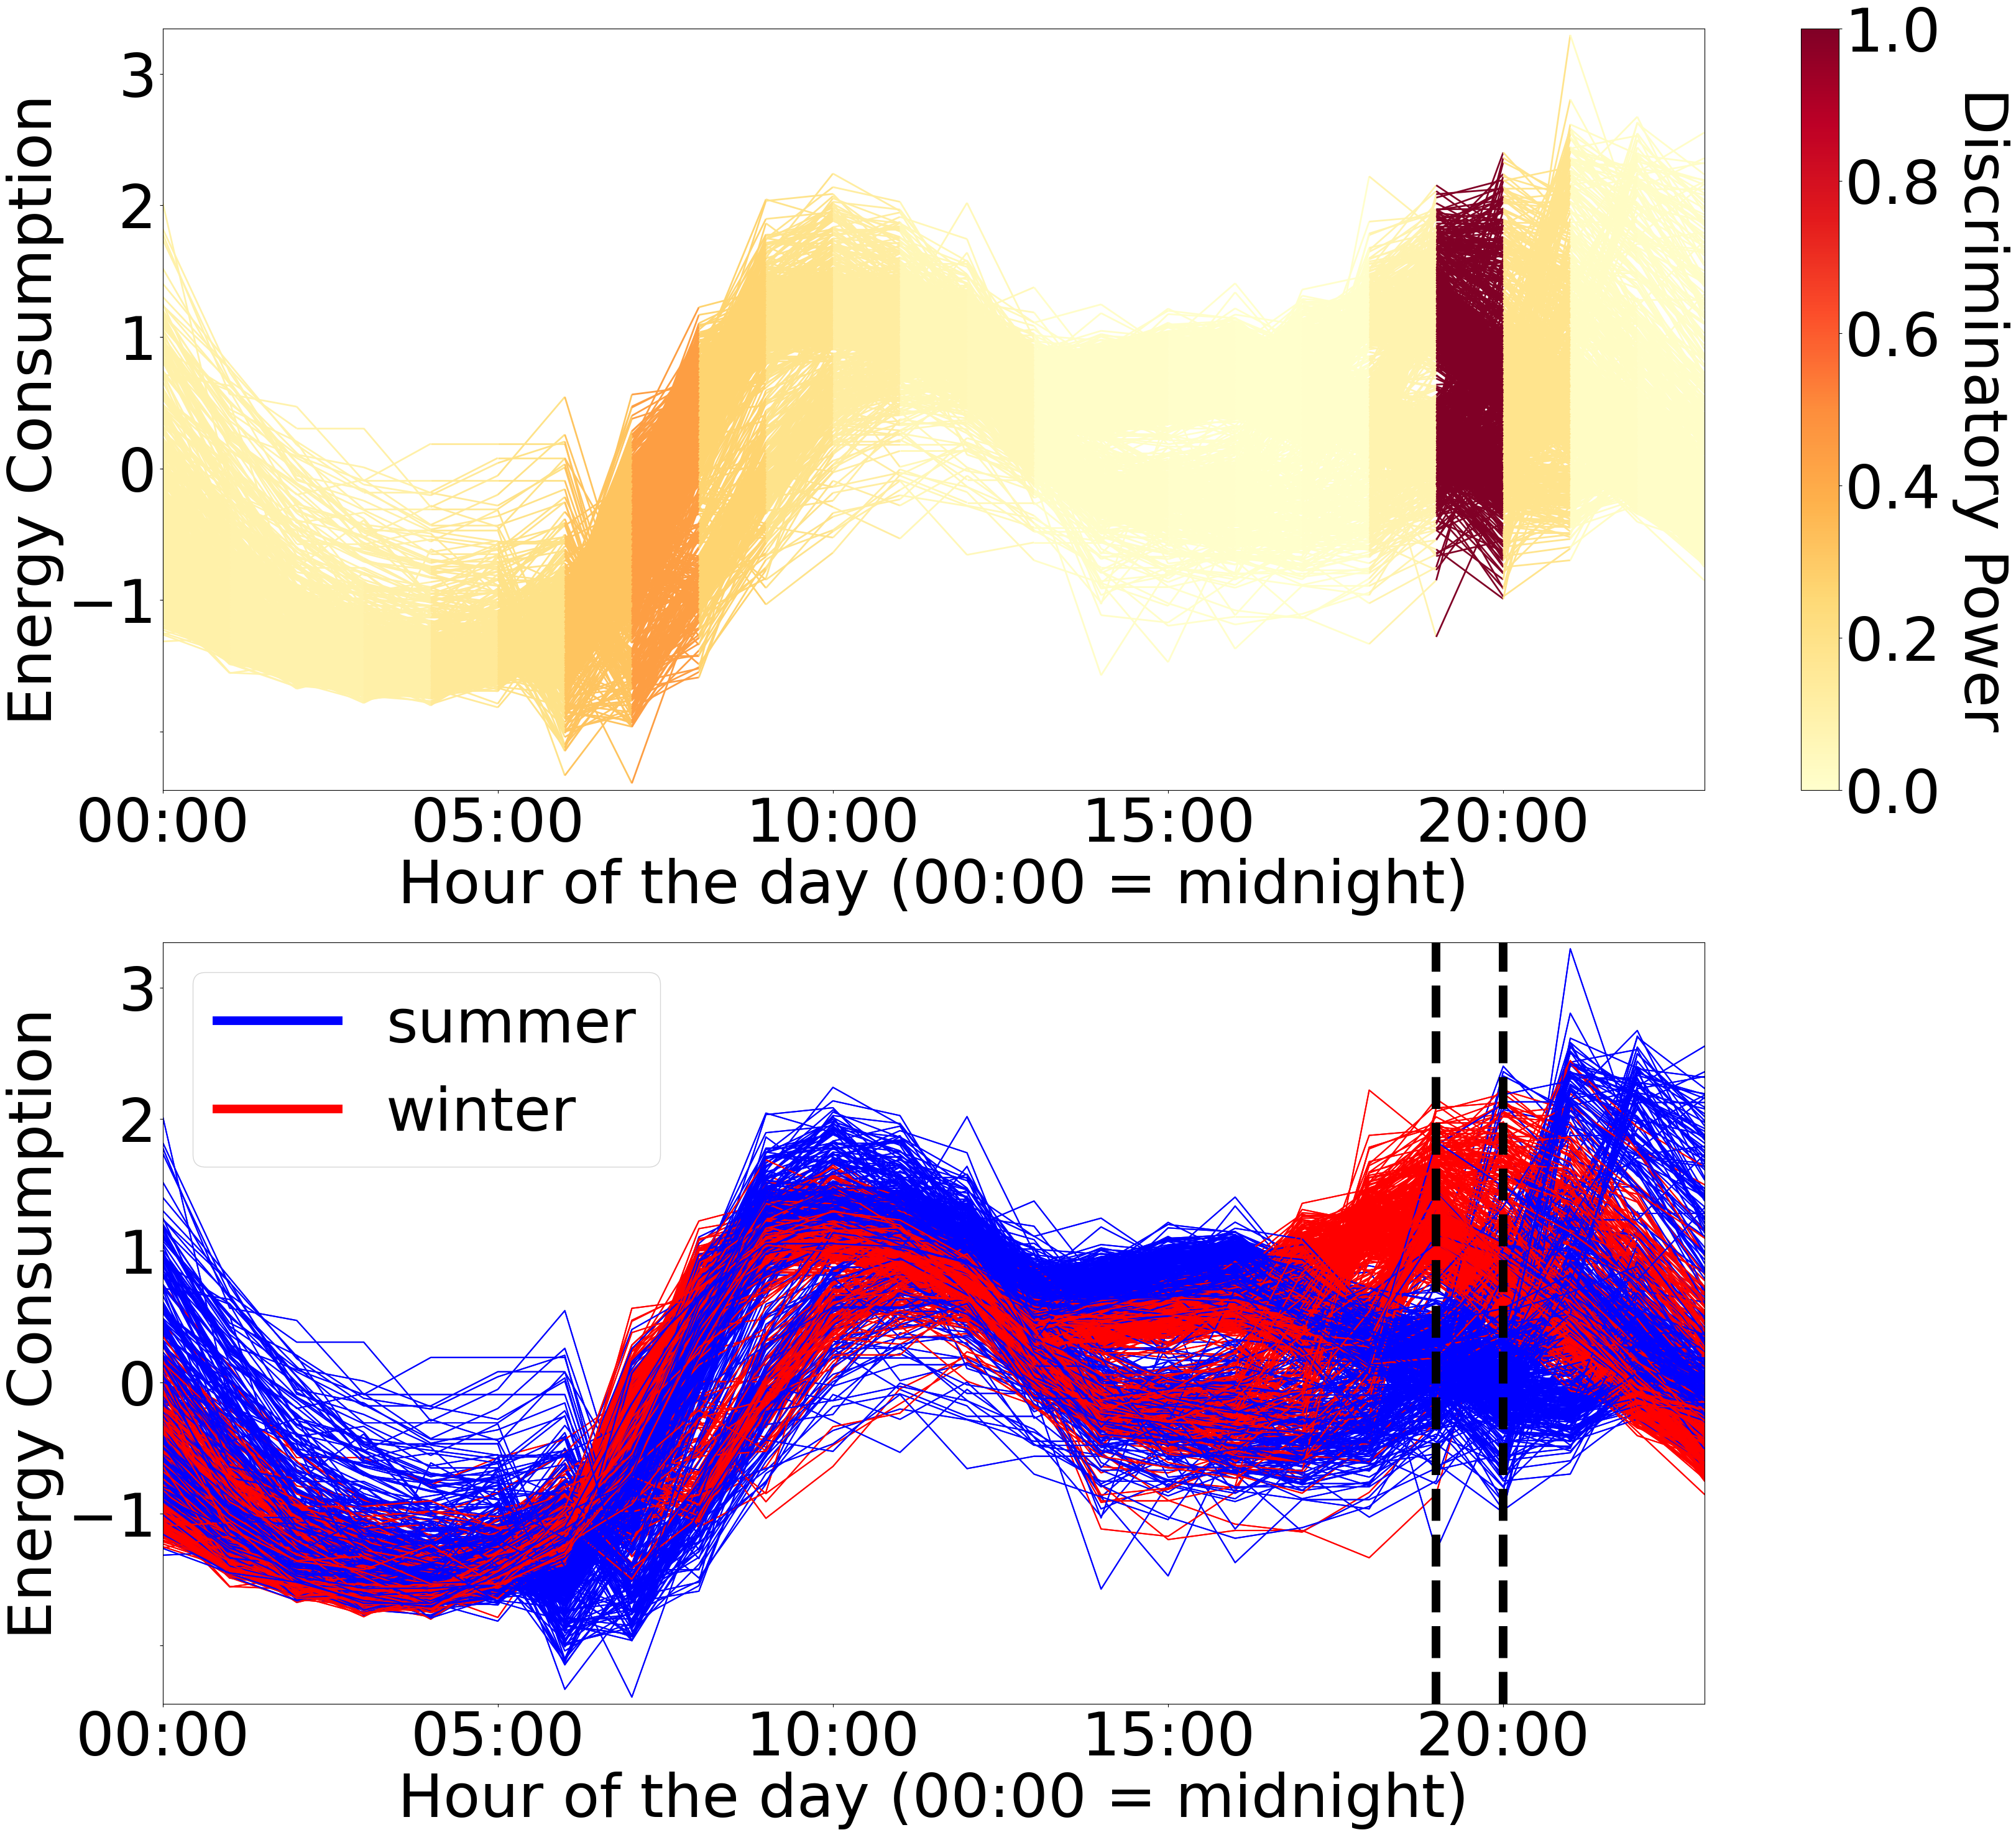

In [8]:
# Some parts of the code below are adapted for the problem of ItalyPowerDemand dataset

r = 500 #number of trees
to_use_start_idx,to_use_end_idx,to_use_agg_fns,to_use_repr_types = trees_start_idx, trees_end_idx, trees_agg_fns, trees_repr_types

nfeats = X_test.shape[1]

per_X_test = getPeriodogramRepr(X_test)
diff_X_test = np.diff(X_test)
ar_X_test = ar_coefs(X_test)

# for this example we use the min aggregation function
agg_fns = [np.min]#np.mean, np.std, np.polyfit, np.median, np.min, np.max, iqr, np.percentile, np.quantile]

for agg_fn in agg_fns:
    for repr_type in [1]:#[1,2,3,4]: #for this example we use the origianl representation
        print('representation type: ', repr_type)
        print('agg fn: ', agg_fn)
        already_used_start_end_idx = []

        for t in range(r):
            all_start_idx_to_use,all_end_idx_to_use = get_all_start_end_idx_per_tree(t, agg_fn, repr_type, to_use_start_idx, to_use_end_idx, to_use_agg_fns, to_use_repr_types)
            if len(all_start_idx_to_use)>0:
                for i in range(len(all_start_idx_to_use)):
                    already_used_start_end_idx.append((all_start_idx_to_use[i],all_end_idx_to_use[i]))


        ######### plot discriminatory regions ###########
        
        if repr_type == 1:
            X_test_to_use = X_test
        elif repr_type == 2:
            X_test_to_use = per_X_test
        elif repr_type == 3:
            X_test_to_use = diff_X_test
        elif repr_type == 4:
            X_test_to_use = ar_X_test
        else:
            print("ERROR")

        
        intensity_map = candDiscrIntFeats_per_aggfn(X_test_to_use,y_test,all_trees_predict,to_use_start_idx,to_use_end_idx,to_use_agg_fns,to_use_repr_types,repr_type,agg_fn)
      
        max_value = np.max(intensity_map)
        min_value = np.min(intensity_map)
        norm_intensity_map =  (intensity_map - min_value) / (max_value-min_value)
        
        fig, ((axs),(ax2)) = plt.subplots(2, 1, figsize=(40,35))
        lstyles= ['-','--','-.',':']

        nrows =  X_test_to_use.shape[0]
        for i in range(nrows):
            x = np.arange(0,len(X_test_to_use[i]))
            y = X_test_to_use[i]
            dydx = norm_intensity_map[i]

            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            norm = plt.Normalize(0,  1)
            lc = LineCollection(segments, cmap='YlOrRd', norm=norm)
            # Set the values used for colormapping
            lc.set_array(dydx)
            lc.set_linewidth(2)

            line = axs.add_collection(lc)
            if i==0:
                fig.colorbar(line, ax=axs)
            axs.tick_params(axis='x', labelsize=70)
            axs.tick_params(axis='y', labelsize=70)
            axs.set_xlim(0,len(y)-1)
            axs.set_ylim(np.min(X_test_to_use)-0.05,np.max(X_test_to_use)+0.05)
            axs.yaxis.get_major_ticks()[1].label1.set_visible(False)
            axs.set_ylabel("Energy Consumption", fontsize=70) # Adapted for ItalyPowerDemand dataset
            axs.set_xlabel("Hour of the day (00:00 = midnight)", fontsize=70) # Adapted for ItalyPowerDemand dataset
    
        cb_ax = fig.axes[2]
        cb_ax.tick_params(labelsize=70)
        cb_ax.get_yaxis().labelpad = 80
        cb_ax.set_ylabel('Discriminatory Power', rotation=270, fontsize=70)
        
        
        f_label = ["00:00", "05:00", "10:00", "15:00", "20:00"] # Adapted for ItalyPowerDemand dataset
        axs.set_xticklabels(f_label)

        X_test_to_use = X_test.copy()

        nrows,ncols = X_test_to_use.shape
        styles = ['r','b','b','k','c','m','y']
        
        
        ########.   Adapted for ItalyPowerDemand dataset  ##########
        already_label_0 = 0
        already_label_1 = 0
        for i in range(nrows):
            label = y_test[i]
            if label==0 and already_label_0==0:
                ax2.plot(X_test_to_use[i,:], styles[label], label="winter")
                already_label_0 = 1
            else:
                ax2.plot(X_test_to_use[i,:], styles[label])
                
            if label==1 and already_label_1==0:
                ax2.plot(X_test_to_use[i,:], styles[label], label="summer")
                already_label_1 = 1
            else:
                ax2.plot(X_test_to_use[i,:], styles[label])
        #############################################################
                

        ax2.tick_params(axis='x', labelsize=70)
        ax2.tick_params(axis='y', labelsize=70)
        ax2.set_xlim(0,ncols-1)
        ax2.set_ylim(np.min(X_test_to_use)-0.05,np.max(X_test_to_use)+0.05)
        ax2.yaxis.get_major_ticks()[1].label1.set_visible(False)
        
        box = ax2.get_position()
        ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        leg = ax2.legend(loc='best', prop={'size': 70})
        
        for legobj in leg.legendHandles:
            legobj.set_linewidth(10)
        
        ax2.set_xticklabels(f_label)
        ax2.set_xlabel("Hour of the day (00:00 = midnight)", fontsize=70) # Adapted for ItalyPowerDemand dataset
        ax2.set_ylabel("Energy Consumption", fontsize=70) # Adapted for ItalyPowerDemand dataset
        ax2.axvline(x=19, c='k', ls="--", linewidth=10)
        ax2.axvline(x=20, c='k', ls="--", linewidth=10)